In [105]:
import pandas as pd
import ast
import re
import string
import spacy
from textblob import TextBlob

In [92]:
train_2_df = pd.read_csv('../datasets/train_df.csv')
sg_entities_patterns_df = pd.read_csv('../datasets/sg_entities_patterns.csv')
data_1 = pd.read_csv('../streamlit/test_sentence/data_1.csv')

In [93]:
sg_entities_patterns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           510 non-null    object
 1   pattern         510 non-null    object
 2   sublocation     510 non-null    object
 3   interest_1      510 non-null    object
 4   interest_2      74 non-null     object
 5   indoor_outdoor  510 non-null    object
dtypes: object(6)
memory usage: 24.0+ KB


In [42]:
def create_empty_list():
    return []

def add_counts(sentiment_words, counts, combined_dict):
    for word, count in zip(sentiment_words, counts):
        if word in combined_dict['sentiment_word']:
            # find the index of the word in the list saved in combined_dict['sentiment_words']
            index_of_word = combined_dict['sentiment_word'].index(word)
            combined_dict['count'][index_of_word] += count
        else:
            combined_dict['sentiment_word'].append(word)
            combined_dict['count'].append(count)
    return combined_dict

In [43]:
remove_entities = ['one','two','first','1','2','3','4','5','6','7','10','30',
                   'ref','kak','juga','ga','bro','kami','sa']

def create_nps_dataframe(sentence_df,sg_entities_patterns_df):
    
    # convert string of list back to a list
    sentence_df['entity'] = sentence_df['entity'].map(lambda x: ast.literal_eval(x))
    sentence_df['pos_sentiment_words'] = sentence_df['pos_sentiment_words'].map(lambda x: ast.literal_eval(x))
    sentence_df['neg_sentiment_words'] = sentence_df['neg_sentiment_words'].map(lambda x: ast.literal_eval(x))

    list_of_lists_all = [entities for entities in sentence_df['entity']]

    unique_entities_count = {}

    # Loop through each sublist in the list of lists
    for sublist in list_of_lists_all:
        # Loop through each string in the sublist
        for word in sublist:
            # need to swap out the word with the replacement from my other list
            # we will only keep entities that are in 'sg_entities_patterns_df'
            if word in sg_entities_patterns_df['pattern'].values:
                # find the row number in which this word is found
                row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == word])[0]
                # replace word with value in 'sublocation'
                word = sg_entities_patterns_df['sublocation'][row_num]
                if word not in remove_entities:
                    # Update the count in the dictionary                 
                    unique_entities_count[word] = unique_entities_count.get(word, 0) + 1

    # save entity and its corresponding count in a dataframe
    unique_entities_count_df = {'entity': [],'count': []}
    for k,v in unique_entities_count.items():
        unique_entities_count_df['entity'].append(k)
        unique_entities_count_df['count'].append(v)
    unique_entities_count_df = pd.DataFrame(unique_entities_count_df)

    # add new columns
    unique_entities_count_df['promoter_count'] = 0
    unique_entities_count_df['detractor_count'] = 0
    unique_entities_count_df['total_count'] = 0
    unique_entities_count_df['pos_sentiment_words'] = 0
    unique_entities_count_df['neg_sentiment_words'] = 0
    unique_entities_count_df['interest_1'] = ''
    unique_entities_count_df['interest_2'] = ''
    unique_entities_count_df['indoor_outdoor'] = ''

    # Apply the function to each cell
    unique_entities_count_df['pos_sentiment_words'] = unique_entities_count_df['pos_sentiment_words'].apply(lambda x: create_empty_list())
    unique_entities_count_df['neg_sentiment_words'] = unique_entities_count_df['neg_sentiment_words'].apply(lambda x: create_empty_list())

    # calculate nps for each entity
    for index, entities in enumerate(sentence_df['entity']):
        # extract the positive and negative sentiment words as a list
        pos_list = sentence_df['pos_sentiment_words'].loc[index]
        neg_list = sentence_df['neg_sentiment_words'].loc[index]
        for entity in entities:
            # we only want the locations mentioned in sg_entities_patterns_df
            if entity in sg_entities_patterns_df['pattern'].values:
                # find the row number in which this word is found
                row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == entity])[0]
                # replace word with value in 'sublocation'
                entity = sg_entities_patterns_df['sublocation'][row_num]        
                # find the row in which this entity is saved in for unique_entities_count_df
                row_num = (unique_entities_count_df.index[unique_entities_count_df['entity'] == entity])
                unique_entities_count_df['total_count'].loc[row_num] = unique_entities_count_df['total_count'].loc[row_num] + 1

                # save the extracted pos and neg words in a list
                unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]] = pos_list + unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]]
                unique_entities_count_df['neg_sentiment_words'].loc[row_num[0]] = neg_list + unique_entities_count_df['neg_sentiment_words'].loc[row_num[0]]

                # add to the respective count if the sentence is a promoter / detractor
                if sentence_df['sentiment'].loc[index] >= 9:
                    unique_entities_count_df['promoter_count'].loc[row_num] = unique_entities_count_df['promoter_count'].loc[row_num] + 1
                elif sentence_df['sentiment'].loc[index] < 6:
                    unique_entities_count_df['detractor_count'].loc[row_num] = unique_entities_count_df['detractor_count'].loc[row_num] + 1

    # nps formula
    unique_entities_count_df['nps'] = ((unique_entities_count_df['promoter_count'] - unique_entities_count_df['detractor_count']) / unique_entities_count_df['count']) * 100

    # add the 'interest_1', 'interest_2' and 'indoor_outdoor' info to the dataframe
    for index, entity in enumerate(unique_entities_count_df['entity']):
        # find the matching entity in 'sg_entities_patterns_df' and get the row_num
        row_num = sg_entities_patterns_df.index[sg_entities_patterns_df['sublocation'] == entity][0]
        unique_entities_count_df['interest_1'].loc[index] = sg_entities_patterns_df['interest_1'].loc[row_num]
        unique_entities_count_df['interest_2'].loc[index] = sg_entities_patterns_df['interest_2'].loc[row_num]
        unique_entities_count_df['indoor_outdoor'].loc[index] = sg_entities_patterns_df['indoor_outdoor'].loc[row_num]

    # for positive words
    for index, list_of_strings in enumerate(unique_entities_count_df['pos_sentiment_words']):
        dictionary = {}
        final_dict = {'sentiment_word': [],'count': []}
        for sentiment_word in list_of_strings:
            dictionary[sentiment_word] = dictionary.get(sentiment_word,0) + 1
        for k, v in dictionary.items():
            final_dict['sentiment_word'].append(k)
            final_dict['count'].append(v)
        # save in the cell
        unique_entities_count_df['pos_sentiment_words'][index] = final_dict

    # for negative words
    for index, list_of_strings in enumerate(unique_entities_count_df['neg_sentiment_words']):
        dictionary = {}
        final_dict = {'sentiment_word': [],'count': []}
        for sentiment_word in list_of_strings:
            dictionary[sentiment_word] = dictionary.get(sentiment_word,0) + 1
        for k, v in dictionary.items():
            final_dict['sentiment_word'].append(k)
            final_dict['count'].append(v)
        # save in the cell
        unique_entities_count_df['neg_sentiment_words'][index] = final_dict
    return unique_entities_count_df

In [44]:
def create_sentiment_words_df(entities_df,pos_or_neg_sentiment_words):
    # reset sorting
    entities_df = entities_df.sort_index()
    
    # new dictionary
    sentiment_words_dict = {'sentiment_word':[],'count':[]}
    
    # for positive words
    for index, interest_1 in enumerate(entities_df[pos_or_neg_sentiment_words]):
        # Add pos_sentiment_words_dict to the combined_dict
        combined_dict = sentiment_words_dict

        # Add counts from unique_entities_count_df['pos_sentiment_words'][index] to the combined_dict
        add_counts(entities_df[pos_or_neg_sentiment_words][index]['sentiment_word'], entities_df[pos_or_neg_sentiment_words][index]['count'],combined_dict)

        # save the combined_dict in pos_sentiment_words_dict
        sentiment_words_dict = combined_dict
        
        # save as dataframe
        sentiment_words_df = pd.DataFrame(sentiment_words_dict)
        sentiment_words_df = sentiment_words_df.sort_values(by=['count'],ascending=False)
    return sentiment_words_df

In [45]:
unique_entities_count_df = create_nps_dataframe(train_2_df,sg_entities_patterns_df)

/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_13853/380868105.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['total_count'].loc[row_num] = unique_entities_count_df['total_count'].loc[row_num] + 1
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_13853/380868105.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]] = pos_list + unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]]
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_13853/380868105.py:69: SettingWithCopyWarning: 
A value is

In [71]:
options = ['singapore airport','food']

In [75]:
unique_entities_count_df.index[unique_entities_count_df['entity'] == 'food']

Int64Index([9], dtype='int64')

In [76]:
for i in options:
    row_num = unique_entities_count_df.index[unique_entities_count_df['entity'] == i][0]
    df = unique_entities_count_df[unique_entities_count_df['entity'] == i].loc[row_num,'pos_sentiment_words']
    print(df)

{'sentiment_word': ['amazing', 'whole', 'best', 'live', 'awesome', 'love', 'favorite', 'incredible', 'available', 'top', 'pretty', 'sure', 'most', 'famous', 'beautiful', 'adult', 'super', 'win', 'perfect', 'fresh', 'dim', 'absolutely', 'really', 'early', 'peaceful', 'fun', 'wild', 'much', 'honestly', 'more', 'accurately', 'real', 'many', 'better'], 'count': [3, 1, 1, 1, 1, 1, 2, 3, 1, 3, 2, 1, 5, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1]}
{'sentiment_word': ['amazing', 'cool', 'pretty', 'lol', 'general', 'best', 'cheap', 'absolutely', 'loved', 'nice', 'better', 'good', 'wow', 'really', 'kind', 'incredible', 'high', 'true', 'much', 'more', 'real', 'honestly', 'enjoy', 'great', 'cultural', 'interesting', 'old', 'mostly', 'top', 'welcome', 'full', 'love', 'sure', 'very', 'delicious', 'worth', 'wise', 'haha', 'hot', 'happy', 'ok', 'most', 'straight', 'importantly', 'own', 'accessible', 'primary', 'many', 'challenging', 'authentic', 'young', 'awesome', 'exciting', 'hone

In [46]:
pos_sentiment_words_df = create_sentiment_words_df(unique_entities_count_df,'pos_sentiment_words').sort_values(by=['count'],ascending=False)

In [48]:
import seaborn as sns

<Axes: xlabel='count', ylabel='sentiment_word'>

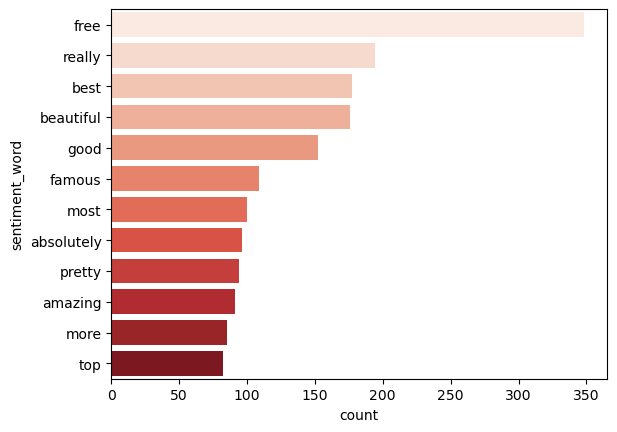

In [50]:
sns.barplot(data=pos_sentiment_words_df.head(12),
            x='count',y='sentiment_word',
           palette='Reds',)

In [95]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  32 non-null     object
dtypes: object(1)
memory usage: 384.0+ bytes


In [110]:
# load spaCy English model
nlp = spacy.load('en_core_web_sm')

# create entity ruler
ruler = nlp.add_pipe('entity_ruler',"ruleActions", config={"overwrite_ents": True})

# list of entities and patterns
# note that the text are lemmatized before pulling for entities. Thus, patterns should be in root form
lst_of_patterns = sg_entities_patterns_df.to_dict('records') # convert df to list of dictionary
patterns = lst_of_patterns

ruler.add_patterns(patterns)

# define function for lemmatization using spaCy
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = ' '.join(token.lemma_ for token in doc)
    return lemmatized_text

In [111]:
def clean_extract_dataframe(data_n):
    # instantiate dataframe
    data_n_mod_df = pd.DataFrame(columns=['sentence','entity','pos_sentiment_words','neg_sentiment_words'])
    
    # find no. of rows in 'video_info_audio_caption_cleaned_df'
    n_rows = len(data_n)

    for i in range(0,n_rows):
        # define text
        text = data_n['sentence'].loc[i]

        # if there are no words in 'final_text_description', it becomes a math nan which is a float
        # thus, to check if there are words, check if type is string or float
        if type(text) == str:
            # split text into smaller sentences
            sentences = re.split(r'[^\w\s\'-,]', text) # NOT a word character, whitespace, single quote, hyphen, or comma

            for sentence in sentences:
                # instantiate a dictionary
                dictionary = {}

                # convert characters to lowercase
                sentence = sentence.lower()
                # remove punctuations
                sentence = sentence.translate(str.maketrans('','',string.punctuation))

                # check if there are words in the sentence
                if sentence != '' and sentence != ' ':
                    # save the sentence in dictionary
                    dictionary['sentence'] = sentence

                    # instantiate 'pos_sentiment_words' and 'neg_sentiment_words'
                    dictionary['pos_sentiment_words'] = []
                    dictionary['neg_sentiment_words'] = []
                    for token in sentence.split():
                        textblob_token = TextBlob(token)
                        if textblob_token.sentiment.polarity > 0:
                            dictionary['pos_sentiment_words'].append(token)
                        elif textblob_token.sentiment.polarity < 0:
                            dictionary['neg_sentiment_words'].append(token)

                    # lemmatize text using function defined above
                    lemmatized_text = lemmatize_text(sentence)
                    lemmatized_doc = nlp(lemmatized_text)

                    # extract entities 
                    entities = [entity for entity in lemmatized_doc.ents]

                    for entity in entities:

                        # if word happens to be in the name of entity, it should not be a sentiment word, remove from pos words
                        for word in dictionary['pos_sentiment_words']:
                            if word in str(entity):
                                dictionary['pos_sentiment_words'].remove(word)
                                sentence = sentence.replace(word,'')
                        # if word happens to be in the name of entity, it should not be a sentiment word, remove from neg words
                        for word in dictionary['neg_sentiment_words']:
                            if word in str(entity):
                                dictionary['neg_sentiment_words'].remove(word)
                                sentence = sentence.replace(word,'')

                    dictionary['entity'] = []
                    for entity in entities:
                        # save the entity in the dictionary
                        dictionary['entity'].append(str(entity))

                    # save the entire dictionary to train_df
                    data_n_mod_df.loc[len(data_n_mod_df)] = dictionary
    return data_n_mod_df

In [112]:
clean_extract_dataframe(data_1)

,sentence,entity,pos_sentiment_words,neg_sentiment_words
0,marina bay sands hotel was amazing,[marina bay sands],[amazing],[]
1,hawker food is cheap,[food],[cheap],[]
2,go to newton hawker center i love the stingra...,[newton hawker center],[love],[]
3,time to visit changi jewel,[jewel],[],[]
4,fort canning was so beautiful,[fort canning],[beautiful],[]
5,art lovers will be captivated by the captivati...,"[art lover, artscience museum]",[captivating],[cutting]
6,edge institution at marina bay sands,[marina bay sand],[],[]
7,explore the lush beauty of singapore botanic g...,[singapore botanic gardens],[lush],[]
8,discover the vibrant streets of chinatown fill...,"[chinatown, food]","[vibrant, filled, colorful, cultural]",[]
9,marina bay sands an iconic landmark in singapo...,"[marina bay sand, singapore]","[iconic, breathtaking, stunning]",[]


In [122]:
unique_entities_count_df.sort_values(by=['count'],ascending=False).head(8)

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
9,food,356,11,30,356,"{'sentiment_word': ['amazing', 'cool', 'pretty...","{'sentiment_word': ['expensive', 'due', 'serio...",food and drinks,NaN,indoor,-5.337079
15,shoppe at marina bay sand,132,1,6,132,"{'sentiment_word': ['nice', 'great', 'many', '...","{'sentiment_word': ['expensive', 'less', 'othe...",shopping,NaN,indoor,-3.787879
36,mrt,128,2,3,128,"{'sentiment_word': ['haha', 'near', 'better', ...","{'sentiment_word': ['confusing', 'usual', 'toi...",transport,NaN,indoor,-0.781250
3,garden by the bay,127,3,4,127,"{'sentiment_word': ['loved', 'most', 'popular'...","{'sentiment_word': ['closed', 'sorry', 'spent'...",nature,architecture,outdoor,-0.787402
31,sentosa,92,3,4,92,"{'sentiment_word': ['pretty', 'nice', 'great',...","{'sentiment_word': ['hidden', 'round', 'wrong'...",recreation,NaN,outdoor,-1.086957
11,hawker centre,87,3,5,87,"{'sentiment_word': ['amazing', 'lol', 'cheap',...","{'sentiment_word': ['seriously', 'fucking', 'c...",food and drinks,NaN,indoor,-2.298851
41,jewel changi,76,3,4,76,"{'sentiment_word': ['lol', 'real', 'free', 'to...","{'sentiment_word': ['unfortunately', 'wrong', ...",shopping,NaN,indoor,-1.315789
28,chinatown,59,1,1,59,"{'sentiment_word': ['cheap', 'rich', 'interest...","{'sentiment_word': ['complex', 'spent', 'harde...",culture,NaN,outdoor,0.000000


In [118]:
unique_entities_count_df['interest_1'].unique()

array(['transport', 'art', 'museum', 'nature', 'architecture', 'park',
       'culture', 'food and drinks', 'religion', 'shopping', 'recreation',
       'wildlife park', 'amusement park', 'historic', 'heritage',
       'payment'], dtype=object)